<a href="https://colab.research.google.com/github/jingxlim/course-content/blob/interactive-track/tutorials/W2D3_DecisionMaking/student/W2D3_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 2, Day 3, Tutorial 2

# Hidden Markov Model

__Content creators:__ Yicheng Fei with help from Jesse Livezey

__Content reviewers:__ John Butler, Matt Krause, Meenakshi Khosla, Spiros Chavlis, Michael Waskom

---

# Tutorial objectives

The world around us is often changing state over time, but we may only have access to these states through noisy sensory measurements. Similarly, organisms and neural systems often are thought to transition between a set of discrete states (up/down states, sleep/wake, etc.) which may only be indirectly observable through their impact on neural activity. Hidden Markov Models are a class of models that allow us to reason about the dynamics of a set of unobserved states that lead to the changing sensory inputs or data we observe.

In this notebook, we'll first simulate a Hidden Markov Model and observe how changing the transition probability and observation noise impact what the samples look like. Then we'll look at how uncertainty increases as we make future predictions without evidence (from observations) and how to gain information from the observations.
The HMM model we use in the first part of the tutorial will have binary latent variable $x_t \in \{0,1\}$ and 1D Gaussian emmision model $y_t|x_t \sim \mathcal{N}(\mu_{x_t},\sigma^2_{x_t})$. You will learn how to:

* Build an HMM in Python and generate sample data.
* Calculate how predictive probabilities propagates in a Markov Chain with no evidence.
* Combine new evidence and prediction from past evidence  to estimate latent states.

---

There is an an **optional** part for you to get a sense of how to perform parameter estimation of an HMM using the EM algorithm. **Please make sure to complete and understand the main exercises before proceeding.**

In the optional part, you will implement an HMM of a network of Poisson spiking neurons mentioned in today's intro and:

* Implement the forward-backward algorithm
* Complete the E-step and M-step 
* Learning parameters for the example problem using the EM algorithm
* Get an intuition of how the EM algorithm monotonically increase data likelihood

Video available at https://youtu.be/ceQXN0OUaFo


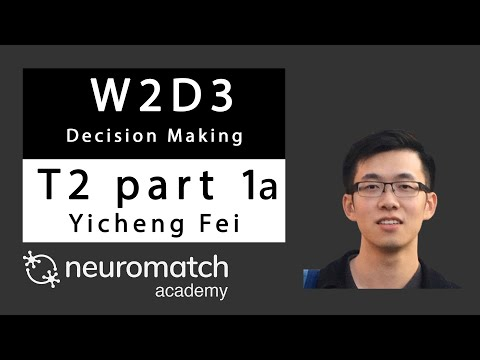

In [ ]:
#@title Video 1: Introduction
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ceQXN0OUaFo", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

In [1]:
!pip install hmmlearn --quiet

import numpy as np
from scipy import stats
from scipy.optimize import linear_sum_assignment
from hmmlearn import hmm

import matplotlib.pyplot as plt
from matplotlib import patches

     |████████████████████████████████| 368kB 1.9MB/s 


In [2]:
#@title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
#@title Helper functions

def plot_hmm1(model, states, observations):
  """Plots HMM states and observations for 1d states and observations.

  Args:
    model (hmmlearn model):               hmmlearn model used to get state means.
    states (numpy array of floats):       Samples of the states.
    observations (numpy array of floats): Samples of the states.
  """

  nsteps = states.size
  fig, ax1 = plt.subplots()
  states_forplot = list(map(lambda s: model.means_[s], states))
  ax1.step(np.arange(nstep), states_forplot, "--", where="mid", alpha=1.0, c="green")
  ax1.set_xlabel("Time")
  ax1.set_ylabel("Latent State", c="green")
  ax1.set_yticks([-1, 1])
  ax1.set_yticklabels(["State 1", "State 0"])

  ax2 = ax1.twinx()
  ax2.plot(np.arange(nstep), observations.flatten(), c="blue")
  ax2.set_ylabel("Observations", c="blue")
  ax1.set_ylim(ax2.get_ylim())
  plt.show(fig)


def plot_marginal_seq(predictive_probs, switch_prob):
  """Plots the sequence of marginal predictive distributions.
    
    Args:
      predictive_probs (list of numpy vectors): sequence of predictive probability vectors
      switch_prob (float):                      Probability of switching states.
  """
  T = len(predictive_probs)
  prob_0 = [p_vec[0] for p_vec in predictive_probs]
  prob_1 = [p_vec[1] for p_vec in predictive_probs]
  fig, ax = plt.subplots()
  ax.plot(np.arange(T), prob_0, color="orange")
  ax.plot(np.arange(T), prob_1, color="blue")
  ax.legend([
    "prob in state 0", "prob in state 1"
  ])
  ax.text(T/2, 0.05, "switching probability={}".format(switch_prob), fontsize=12,
          bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.6))
  ax.set_xlabel("Time")
  ax.set_ylabel("Probability")
  ax.set_title("Forgetting curve in a changing world")
  plt.show(fig)

def simulate_prediction_only(model, nstep):
  """
  Simulate the diffusion of HMM with no observations

  Args:
    model (hmm.GaussianHMM instance): the HMM instance
    nstep (int): total number of time steps to simulate(include initial time)

  Returns:
    predictive_probs (list of numpy vector): the list of marginal probabilities
  """
  entropy_list = []
  predictive_probs = []
  prob = model.startprob_
  for i in range(nstep):
    # calculate entropy
    predictive_probs.append(prob)  
    # one step forward
    prob = markov_forward(prob, model.transmat_)  
  return predictive_probs

def plot_evidence_vs_noevidence(posterior_matrix, predictive_probs):
  """Plots the average posterior probabilities with evidence v.s. no evidence
    
  Args:
    posterior_matrix: (2d numpy array of floats): The posterior probabilities in state 1 from evidence (samples, time)
    predictive_probs (numpy array of floats):  Predictive probabilities in state 1 without evidence
  """
  nsample, T = posterior_matrix.shape
  posterior_mean = posterior_matrix.mean(axis=0)
  fig, ax = plt.subplots(1)
  ax.plot([0.0, T],[0.5, 0.5], color="red", linestyle="dashed")
  ax.plot(np.arange(T), predictive_probs, c="orange", linewidth=2, label="No evidence")
  ax.scatter(np.tile(np.arange(T), (nsample, 1)), posterior_matrix, s=0.8, c="green", alpha=0.3, label="With evidence(Sample)")
  ax.plot(np.arange(T), posterior_mean, c='green', linewidth=2, label="With evidence(Average)")
  ax.legend()
  ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
  ax.set_xlabel("Time")
  ax.set_ylabel("Probability in State 0")
  ax.set_title("Gain confidence with evidence")
  plt.show(fig)

def simulate_forward_inference(model, T, data=None):
  """
  Given HMM `model`, calculate posterior marginal predictions of x_t for T-1 time steps ahead based on
  evidence `data`. If `data` is not give, generate a sequence of observations from first component.

  Args:
    model (GaussianHMM instance): the HMM
    T (int): length of returned array

  Returns:
    predictive_state1: predictive probabilities in first state w.r.t no evidence
    posterior_state1: posterior probabilities in first state w.r.t evidence
  """
  
  # First re-calculate hte predictive probabilities without evidence
  predictive_probs = simulate_prediction_only(model, T)
  # Generate an observation trajectory condtioned on that latent state x is always 1
  if data is not None:
    Y = data
  else:
    Y = np.asarray([model._generate_sample_from_state(0) for _ in range(T)])
  # Calculate marginal for each latent state x_t 
  pt = np.exp(model._compute_log_likelihood(Y[[0]])) * model.startprob_
  pt /= np.sum(pt)
  posterior_probs = np.zeros((T, pt.size))
  posterior_probs[0] = pt

  for t in range(1, T):
    posterior = one_step_update(model, posterior_probs[t-1], Y[[t]])
    # normalize and add to the list
    posterior /= np.sum(posterior)
    posterior_probs[t] = posterior
  posterior_state1 = np.asarray([p[0] for p in posterior_probs])
  predictive_state1 = np.asarray([p[0] for p in predictive_probs])
  return predictive_state1, posterior_state1

def plot_forward_inference(model, states, observations, states_inferred):
    """Plot ground truth state sequence with noisy observations, and ground truth states v.s. inferred ones
        
        Args:
            model (instance of hmmlearn.GaussianHMM): an instance of HMM
            states (numpy vector): vector of 0 or 1(int or Bool), the sequences of true latent states
            observations (numpy vector of numpy vector): the un-flattened Gaussian observations at each time point, element has size (1,)
            states_inferred (numpy vector): vector of 0 or 1(int or Bool), the sequences of inferred latent states
    """
    plot_hmm1(model, states, observations)
    fig, ax = plt.subplots()
    # state 0 has larger mean
    ax.step(np.arange(nstep), 1-states, color="green", label="Ground Truth")
    ax.step(np.arange(nstep), 1-states_inferred, linestyle="dashed", color="orange", label="Inferred")
    ax.legend()
    ax.set_title("Infer latent states from data")
    ax.set_xlabel("Time")
    ax.set_ylabel("Latent State")
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["State 1", "State 0"])
    plt.show(fig)

---
# Section 1: Binary HMM with Gaussian observations

Video available at https://youtu.be/7cTnoe6Xt80


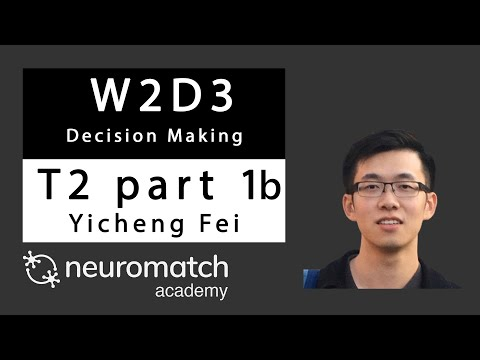

In [ ]:
#@title Video 2: Simulating a binary HMM with Gaussian observations
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="7cTnoe6Xt80", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

### EXERCISE 1: Simulate a binary HMM with Gaussian observations

In contrast with the Sequential Probability Ratio Test, the latent state in HMMs is no longer fixed over time. Instead, it can probabilistically switch or jump to a different state at each time step. However, the  time dependence of states at different times is simple: the probability of the state at time $t$ is totally determined by the state at time $t-1$. This is called called the **Markov property** or **Markovian** and the dependency of the whole state sequence $\{x_1,...,x_t\}$ can be described by a chain structure called a Markov Chain:

<img src=" https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial2_markov_chain_diagram.png?raw=true" alt="Markov chain drawing" width="400"/>

Quantitatively, assuming we are at state $i$ at time $t-1$, and denote the probability to jump to state $j$ at next time point $t$ as $A_{ij}$, then the distribution at time $t$ can be calculated using only probabilities at $t-1$ and the transition matrix $A$:

$$ p(x_t=j) = \sum_j A_{ij} p(x_{t-1}=i) \tag{1}$$

$A_{ij}$ represents the transition probability to switch **FROM state $i$ TO state $j$** at next time step. Please note that this is contrast to the meaning used in the intro.

We cannot directly observe the latent states $x_t$. What we can observe instead is a noisy measurement $y_t$ generated from $x_t$. Common choices of measurement/emission models include Gaussian distribution $y_t|x_t \sim \mathcal{N}(\mu_{x_t},\sigma^2_{x_t})$ for continuous observables, and Poisson distribution $y_t|x_t \sim \text{Pois}(\lambda)$ for discrete observables (like spike counts).

---

In this exercise, you will use the package `hmmlearn` to implement a two-state HMM with Gaussian emissions. Your HMM will start in State 0 and transition between states (both $0 \rightarrow 1$ and $1 \rightarrow 0$) with probability `switch_prob`. Each state emits observations drawn from a Gaussian with $\mu = 1$ for State 0 and $\mu = -1$ for State 1. The variance of both states is fixed at `noise_level`.

Please familarize yourself with the code and complete the following exercises in the next cell. You will need to:

1. To implement the state transitions, complete the transition matrix  `transmat_` (i.e., $A_{ij}$) in the code below. 
\begin{equation*}
A_{i,j} = 
\begin{pmatrix}
p_{stay} & p_{switch} \\
p_{switch} & p_{stay} \\
\end{pmatrix}
\end{equation*}
with $p_{stay} = 1 - p_{switch}$. 

2. The *hidden* part of HMM means that we do not directly output the current state $x_t$, but instead observe a noisy emission $y_t | x_t$, here generated by a Gaussian. The  means have already been filled in for you, but you must complete the covariance matrix `covars_`. Set each state's observation variance to `noise_level`. The required shape, given below, is unusual, but don't overthink finding the (co)variance of a univariate Gaussian. 

3. Use the provided code to run and plot one realization of the HMM's output. 
4. Try different transition (`switch_prob`) and noise levels (`noise_level`) and observe their impact on the samples. You can do this by hand or use the widget in section **Interactive Cell**.




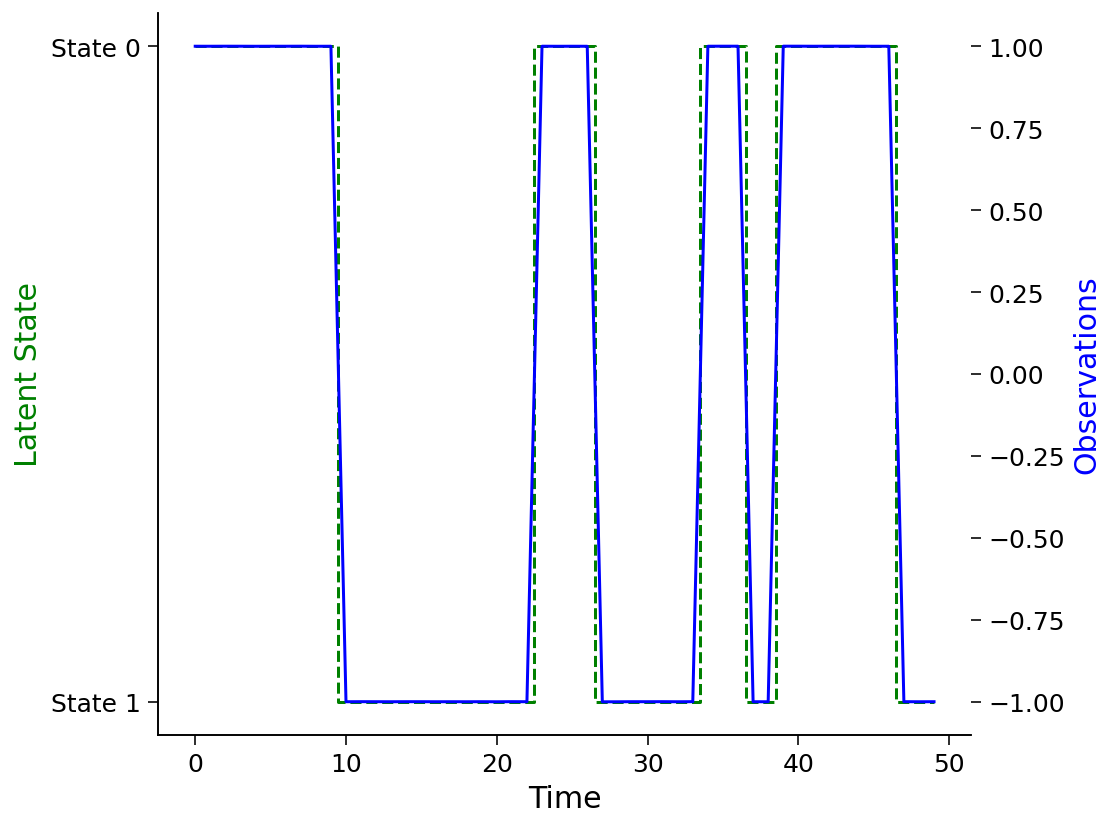

In [10]:
def create_model(switch_prob=0.1, noise_level=1e-8, startprob=[1.0, 0.0]):
    """Create an HMM with binary state variable and 1D Gaussian observations
    The probability to switch to the other state is `switch_prob`. Two
    observation models have mean 1.0 and -1.0 respectively. `noise_level`
    specifies the standard deviation of the observation models.

    Args:
        switch_prob (float): probability to jump to the other state
        noise_level (float): standard deviation of observation models. Same for
        two components

    Returns:
        model (hmm.GaussianHMM instance): the described HMM
    """
    ############################################################################
    # Insert your code here to:
    #    * Create the transition matrix, `transmat_` so that the odds of
    #      switching is `switch_prob`
    #		* Set the observation model variances, `covars_`, to `noise_level`
    # raise NotImplementedError("`create_model` is incomplete")
    ############################################################################
    n_components = 2
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="full")
    model.startprob_ = np.asarray(startprob)
    # should be shape (2, 2), i.e., a transition matrix for 2 states
    stay_prob = 1. - switch_prob
    model.transmat_ = np.array([[stay_prob, switch_prob],
                                [switch_prob, stay_prob]])
    model.means_ = np.array([[1.0], [-1.0]])

    # should be shape (2, 1, 1), i.e., 2 1x1 covariance matrices
    model.covars_ = np.ones((2, 1, 1)) * noise_level
    model.sample(1)
    return model


np.random.seed(101)
nstep = 50
###############################################################################
## After finishing the above exercises, please un-comment the following lines
###############################################################################
model = create_model()
observations, states = model.sample(nstep)
plot_hmm1(model, states, observations)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D3_DecisionMaking/solutions/W2D3_Tutorial2_Solution_75397371.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial2_Solution_75397371_0.png>



In [11]:
#@title 

#@markdown Make sure you execute this cell to enable the widget!
np.random.seed(101)
nstep = 100

@widgets.interact
def plot(switch_prob=(0., 1, .01), log10_noise_level=(-8., 1., .01)):
  model = create_model(switch_prob=switch_prob,
                     noise_level=10.**log10_noise_level)

  observations, states = model.sample(nstep)
  observations = observations.flatten()
  plot_hmm1(model, states, observations)

interactive(children=(FloatSlider(value=0.5, description='switch_prob', max=1.0, step=0.01), FloatSlider(value…

---

# Section 2: Forgetting information and gaining confidence with a known initial state

Video available at https://youtu.be/pRRo_L-n8nc


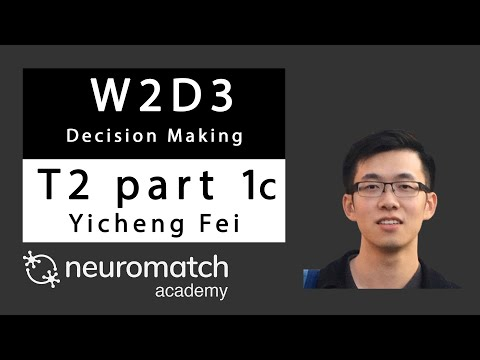

In [ ]:
#@title Video 3: Forgetting in a changing world
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="pRRo_L-n8nc", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

### EXERCISE 2: Forgetting in a changing world

Since the world (latent state) is changing over time, even if we know for sure that we are in state 0 at some time, we will be more and more uncertain that we'll remain in state 0 as time goes. In other words, when we try to make predictions of future states in a Markov Chain based on our current knowledge without future evidence, the influence of current state will decay over time.

In this exercise, we'll inspect how we "forget" the current state information when predicting future states without any observation.

Using the model you just defined, let's now make some predictions about $x_t$ given that we know $x_0=0$ for sure. We've already imposed this assumption by setting prior probabilities of $p(x_0)$ to $[1,0]$ earlier. 

**Suggestions** 


1. Complete the code in function `markov_forward` to calculate the predictive marginal distribution at next time step using `p_next = A.T @ p_current` 

3. Take a look at function `simulate_prediction_only` and understand how the predictive distribution propagates along the Markov chain

4. Using our provided code, plot the predictive probabilities as a function of time

5. Try different values of switching probability (`prob_switch`) either by hand or the widget in section **Interactive Cell** and observe how that affects the forgetting curve of current state. How does the curve look at when `prob_switch` $>0.5$?




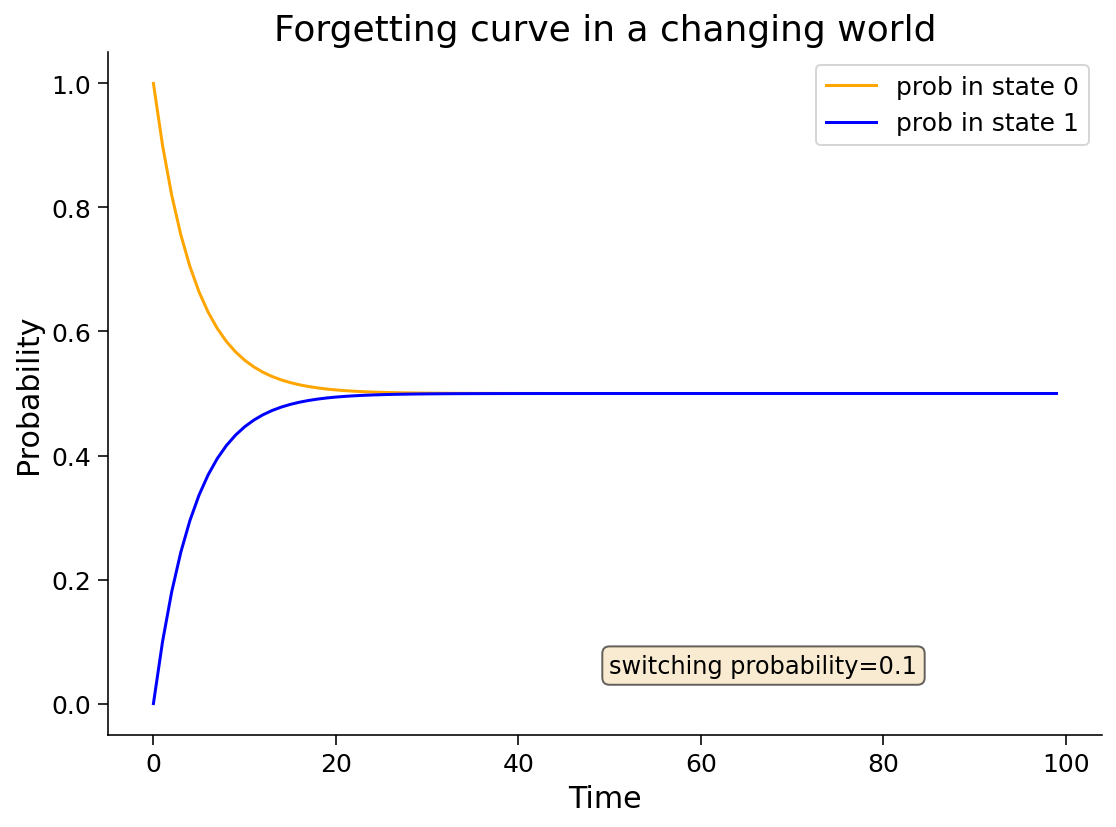

In [13]:
def markov_forward(p0, A):
  """Calculate the forward predictive distribution in a discrete Markov chain

  Args:
    p0 (numpy vector): a discrete probability vector
    A (numpy matrix): the transition matrix, A[i,j] means the prob. to
    switch FROM i TO j

  Returns:
    p1 (numpy vector): the predictive probabilities in next time step
  """
  ############################################################################
  # Insert your code here to:
  #      Compute the marginal distribution of Markov chain in next time step
  #      Hint: use matrix multiply and be careful about the index orders
  # raise NotImplementedError("function `markov_forward` incomplete")
  ############################################################################
  p1 = A@p0
  return p1


np.random.seed(101)
T = 100
switch_prob = 0.1
noise_level = 2.0
################################################################################
# After finishing the above exercises, please un-comment the following lines
################################################################################
model = create_model(switch_prob=switch_prob, noise_level=noise_level)
predictive_probs = simulate_prediction_only(model, T)

plot_marginal_seq(predictive_probs, switch_prob)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D3_DecisionMaking/solutions/W2D3_Tutorial2_Solution_533408ce.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial2_Solution_533408ce_0.png>



- In the following interactive cell, play with different switching probabilities with the slider and observe how that affects the information loss.

In [14]:
#@title 

#@markdown Make sure you execute this cell to enable the widget!
np.random.seed(101)
T = 100
noise_level = 0.5

@widgets.interact
def plot(switch_prob=(0.01, .99, .01)):
  model = create_model(switch_prob=switch_prob, noise_level=noise_level)
  predictive_probs = simulate_prediction_only(model, T)
  plot_marginal_seq(predictive_probs, switch_prob)

interactive(children=(FloatSlider(value=0.5, description='switch_prob', max=0.99, min=0.01, step=0.01), Output…

### EXERCISE 3: Gain confidence from evidence

Video available at https://youtu.be/dDjoxUxMgC0


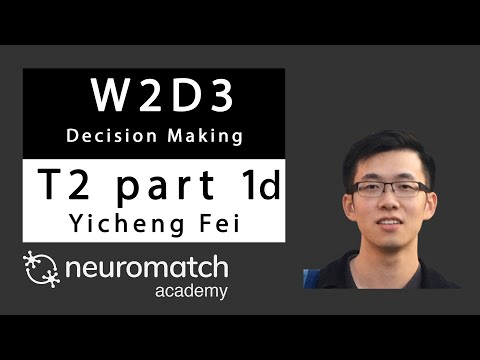

In [ ]:
#@title Video 4: Gain confidence from evidence
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="dDjoxUxMgC0", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

As shown in Exercise 2, you lose information/gain uncertainty exponentially when predicting into future without further evidence because the Markov Chain in HMM will diffuse through a exponential number of possible paths. However HMM generates an observation at each time step and we can use these as evidence to improve our state estimate.

<img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial2_HMM_diagram.png?raw=true" alt="HMM drawing" width="400"/>

Now let's incorporate evidence into our inference. In this exercise we will calculate the **posterior marginal** distribution $p(x_t|y_{1:t})$ recursively when evidence $y_t$ comes in at each time using the forward pass of the forward-backward algorithm.
That is saying, suppose we know the posterior marginal of $x_{t-1}$ given all observations up to $t-1$, when a new observation $y_t$ comes in, from Bayes' rule and the Markov property, we can get $p(x_{t}|y_{1:t})\propto p(x_t|y_{1:t-1})p(y_{t}|x_t)$, where the first term is the prediction which can be calculated as shown in last exercise and the second term in the new data likelihood for two Gaussian observation models:

$$\text{Posterior}(x_t|y_{1:t}) \propto \text{Prediction}(x_t|y_{1:t-1}) \odot \text{Likelihood}(y_t|x_t)$$

**Suggestions**

1. Create a model with switching probability $0.1$ and noise level $0.5$ using function `create_model(switch_prob, noise_level)`

2. Complete the code to calculate marginal posterior distribution $p(x_t|y_{1:t-1})$ at time $t$  from last posterior $p(x_{t-1}|y_{1:t-1})$ at time $t-1$ 
    - Calculate the predictive distrubition $p(x_t =j|y_{1:t-1})=\sum_i A_{ij} p(x_{t-1}=i|y_{1:t-1})$
    - Calculate the likelihood of new data under each component using `exp(model._compute_log_likelihood(yt))`
    - Multiply likelihood and prediction element-wise and normalize over two components to get the new posterior probabilities

3. Using provided code, plot the average posterior probabilities over time due to evidence together with predictive probabilities without evidence


4. Try different values of switching probability (`prob_switch`) and noise level (`noise_level`) either by hand or the widget in section **Interactive Cell** and observe how that affects the posterior probabilities



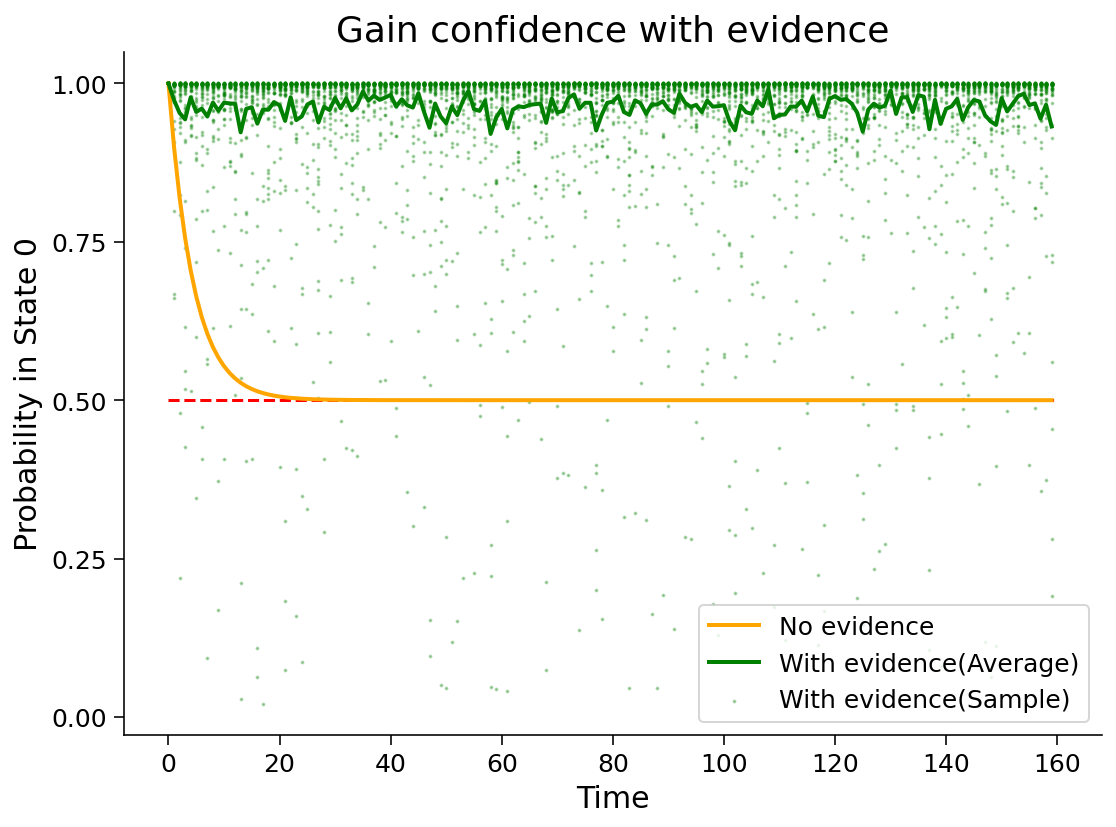

In [16]:
def one_step_update(model, posterior_tm1, Y_t):
  """Given a HMM model, calculate the one-time-step updates to the posterior.

  Args:
    model (GaussianHMM instance): the HMM
    posterior_tm1 (numpy array): Posterior at `t-1`
    Y_t (numpy array): Observation at `t`

    Returns:
    posterior_t (numpy array): Posterior at `t`
  """
  ##############################################################################
  # Insert your code here to:
  #      1. Calculate the predicted state given the previous
  #      estimate (`posterior_tm1`). Note that `model.transmat_` is equvalent
  #      to `A.T`, not `A`.
  #      2. Using `model._compute_log_likelihood()`, calculate the likelihood
  #      given `Y_t`.
  # raise NotImplementedError("`one_step_update` is incomplete")
  ##############################################################################
  prediction = model.transmat_ @ posterior_tm1
  likelihood = np.exp(model._compute_log_likelihood(Y_t))
  posterior_t = prediction * likelihood
  return posterior_t


np.random.seed(101)
switch_prob = 0.1
noise_level = 0.5
nsample = 50
T = 160
###############################################################################
# After finishing the above exercise, please un-comment the following lines
###############################################################################
model = create_model(switch_prob, noise_level)

posterior_list = []
for i in range(nsample):
  predictive_probs, posterior_probs = simulate_forward_inference(model, T)
  posterior_list.append(posterior_probs)
posterior_matrix = np.asarray(posterior_list)

plot_evidence_vs_noevidence(posterior_matrix, predictive_probs)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D3_DecisionMaking/solutions/W2D3_Tutorial2_Solution_12fb68dc.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial2_Solution_12fb68dc_0.png>



Now you've got a plot of information loss due to diffusion together with the information recovered/uncertainty reduced due to evidence. The difference between the former and the latter is the amount of uncertainty that still remains because of observation noise. You could get a sense of this by changing the noise level in the following cell.

**Suggestions**

- In the following interactive cell, adjust the switch probability and noise level and observe how information gain changes with signal-to-noise ratio and/or switch probability.

In [17]:
#@title 

#@markdown Make sure you execute this cell to enable the widget!
np.random.seed(101)
@widgets.interact
def plot(switch_prob=(0.01, .99, .01), noise_level=(.1, 3, .05),
         nsample=(5, 200, 5), T=(20, 300, 5)):
  model = create_model(switch_prob, noise_level)
  posterior_list = [] 
  for i in range(nsample):
    predictive_probs, posterior_probs = simulate_forward_inference(model, T)
    posterior_list.append(posterior_probs)
  posterior_matrix = np.asarray(posterior_list)
  plot_evidence_vs_noevidence(posterior_matrix, predictive_probs)

interactive(children=(FloatSlider(value=0.5, description='switch_prob', max=0.99, min=0.01, step=0.01), FloatS…

---

# Section 3: Inference in a dynamic world



### EXERCISE 4: Forward inference of HMM

If you set `switch_prob` or `noise_level` to be large in the last exercise, you will observe that some sample inference dots fall below 0.5. This means we are making false inferences about which latent state we are in. 

In this exercise, let's make a forward inference of a random state sequence rather than a constant one by observing its noisy Gaussian outputs. Different from Exercise 1, here we assume we know the switching probability but don't know the prior (`startprob_`).

**Suggestions**

1. Build a HMM with prior probabilities= $(0.5,0.5)$, switching probability=$0.1$, and noise level=$1.0$ by calling `create_model(switch_prob, noise_level, startprob)`
2. Generate a sample sequence along with observations by calling `model.sample(nstep)`, and use our provided code to visualize the latent trajectory and observations
3. Calculate posterior probabilities given data by calling `simulate_forward_inference(model, nstep, observations)`, and make inference of latent states by picking the component with larger posterior probability
4. Use our provided code to visualize the inferred state sequence together with the ground truth
5. Try different values of switching probability (`prob_switch`) and noise level (`noise_level`) either by hand or the widget in section **Interactive Cell**. When do we start to make false inferences?





In [ ]:
np.random.seed(101)
nstep = 100
switch_prob = 0.1
log10_noise_level = -1

# Build model 
model = create_model(switch_prob=switch_prob,
                     noise_level=10.**log10_noise_level,
                     startprob=[0.5, 0.5])
observations, states = model.sample(nstep)
# Infer state sequence
predictive_probs, posterior_probs = simulate_forward_inference(model, nstep,
                                                               observations)

############################################################################
# Insert your code here to:
#      Calculate inferred states from posterior probabilities at state 0
#      Hint: Compare the probabilities with 0.5 and note that you should
#            return 0 if prob > 0.5
############################################################################
# states_inferred = ...

################################################################################
# After finishing the above exercises, please un-comment the following lines
################################################################################
#plot_forward_inference(model, states, observations, states_inferred)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D3_DecisionMaking/solutions/W2D3_Tutorial2_Solution_4fe44495.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial2_Solution_4fe44495_0.png>

<img alt='Solution hint' align='left' width=560 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial2_Solution_4fe44495_1.png>



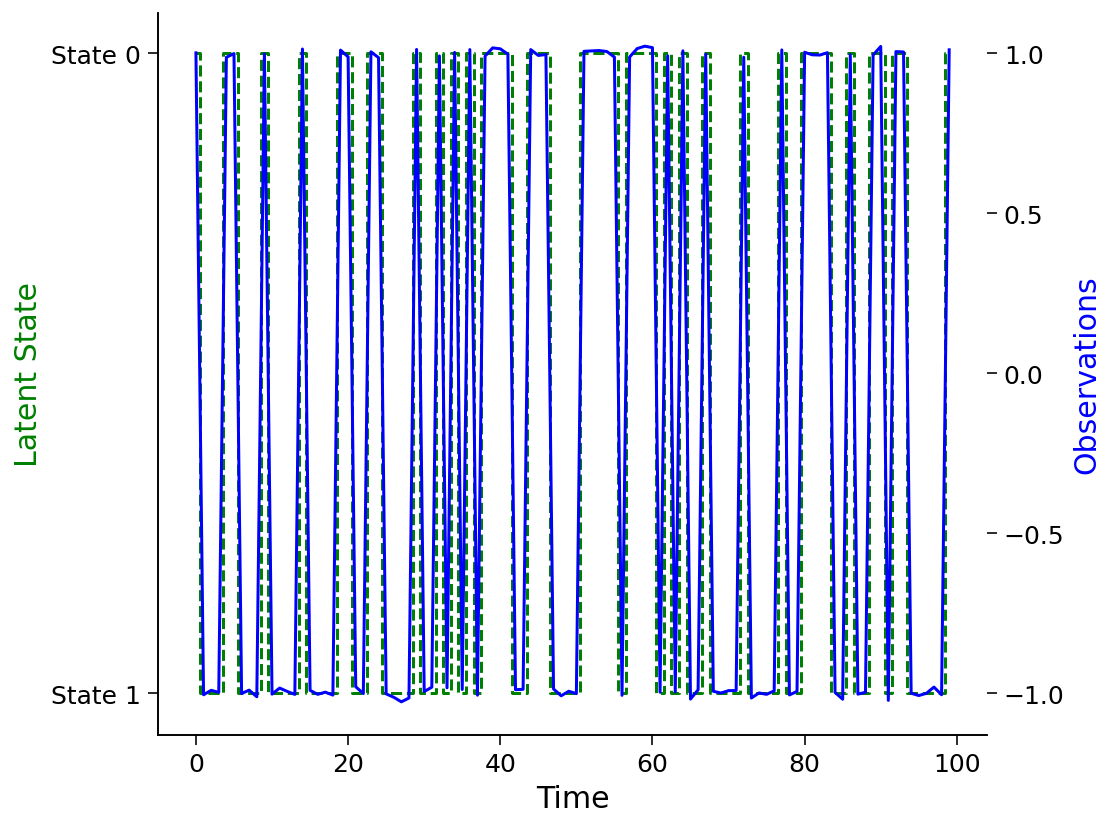

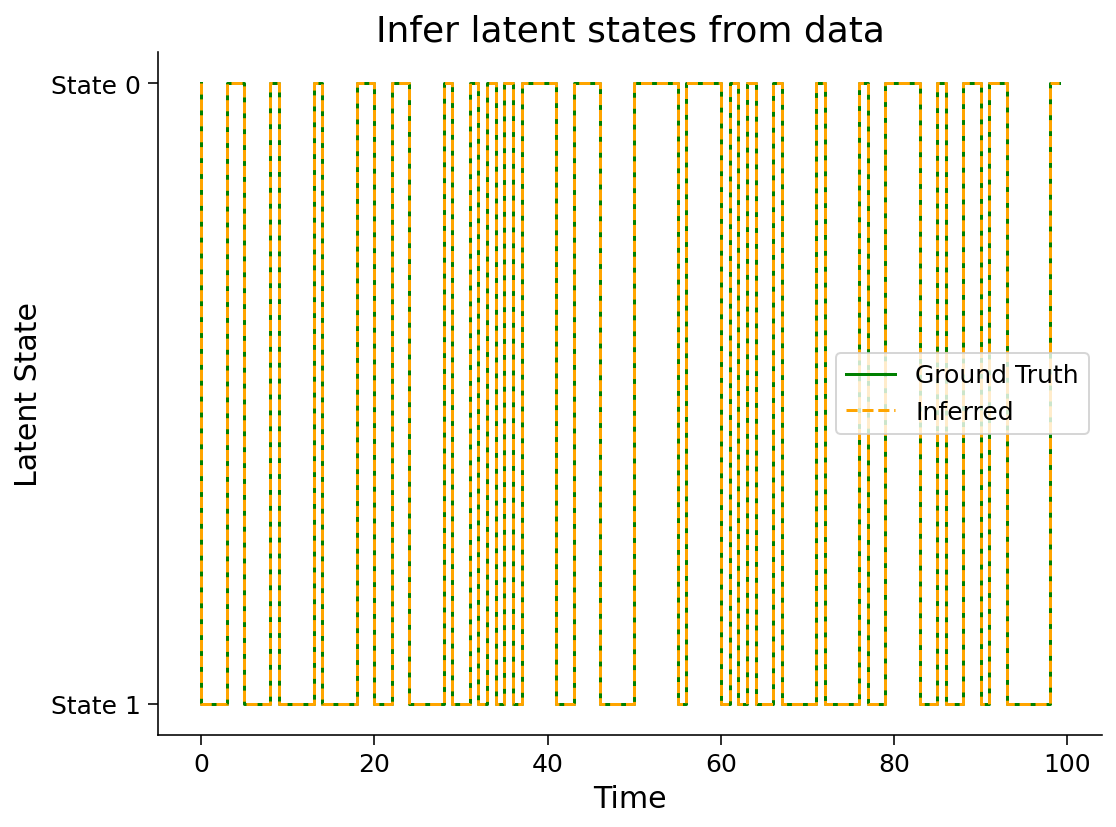

In [ ]:
#@title 

#@markdown Make sure you execute this cell to enable the widget!
np.random.seed(101)
nstep = 100

@widgets.interact
def plot(switch_prob=(0.01, .99, .01), log10_noise_level=(-8, 1, .01)):
  model = create_model(switch_prob=switch_prob,
                      noise_level=10.**log10_noise_level,
                      startprob = [0.5,0.5])
  observations, states = model.sample(nstep)
  # observations = observations.flatten()
  # Infer state sequence
  predictive_probs, posterior_probs = simulate_forward_inference(model, nstep, observations)
  states_inferred = posterior_probs <= 0.5
  plot_forward_inference(model, states, observations, states_inferred)


---

# **Optional** Section: HMM for Poisson spiking neuronal network

Video available at https://youtu.be/Wb8mf5chmyI


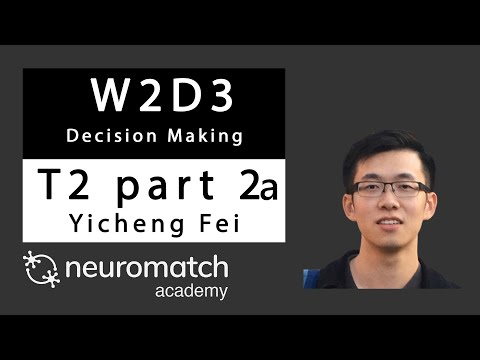

In [ ]:
#@title Video 5: HMM for Poisson spiking neurons case study
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Wb8mf5chmyI", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Given noisy neural or behavioral measurements, we as neuroscientists often want to infer the unobserved latent variables as they change over time. Thalamic relay neurons fire in two distinct modes: a tonic mode where spikes are produced one at a time, and a 'burst mode' where several action potentials are produced in rapid succession. These modes are thought to differentially encode how the neurons relay information from sensory receptors to cortex. A distinct molecular mechanism, T-type calcium channels, switches neurons between modes, but it is very challenging to measure in the brain of a living monkey. However, statistical approaches let us recover the hidden state of those calcium channels purely from their spiking activity, which can be measured in a behaving monkey.

Here, we're going to tackle a simplified version of that problem.


Let's consider the formulation mentioned in the intro lecture. 
We have a network of $C$ neurons switching between $K$ states. Neuron $c$ has firing rate $\lambda_i^c$ in state $i$. The transition between states are represented by the $K\times K$ transition matrix $A_{ij}$ and initial probability vector $\psi$ with length $K$ at time $t=1$.

Let $y_t^c$ be the number of spikes for cell $c$ in time bin $t$.

In the following exercises (4 and 5) and tutorials, you will

* Define an instance of such model with $C=5$ and $K=3$
* (**Exercise 4**) Generate a dataset from this model
* (**Exercise 5**) Implement the M-step for this HMM
* Run EM to estimate all parameters $A,\psi,\lambda_i^c$
* Plot the learning likelihood curve
* Plot expected complete log likelihood versus data log likelihood
* Compare learnt parameters versus true parameters 

---


## **Optional** Section: Define model and generate data

Let's first generate a random state sequence from the hidden Markov Chain, and generate `n_frozen_trials` different trials of spike trains for each cell assuming they all use the same underlying sequence we just generated.

**Suggestions**

1. Run the following two sections **Model and simulation parameters** and **Initialize true model** to define a true model and parameters that will be used in our following exercises. Please take a look at the parameters and come back to these two cells if you encounter a variable you don't know in the future.

2. Complete the code to convert a given state sequence to corresponding spike rates for all cells at all times, and use provided code to visualize all spike trains.



In [ ]:
#@title Helper functions
def plot_spike_train(X, Y, dt):
    """Plots the spike train for cells across trials and overlay the state.
        
      Args:
        X: (2d numpy array of binary values): The state sequence in a one-hot
                                              representation. (T, states)
        Y: (3d numpy array of floats):        The spike sequence.
                                              (trials, T, C)
        dt (float):                           Interval for a bin.
    """
    n_trials, T, C = Y.shape
    trial_T = T * dt
    fig = plt.figure(figsize=(.7 * (12.8 + 6.4), .7 * 9.6))

    # plot state sequence
    starts = [0] + list(np.diff(X.nonzero()[1]).nonzero()[0])
    stops = list(np.diff(X.nonzero()[1]).nonzero()[0]) + [T]
    states = [X[i + 1].nonzero()[0][0] for i in starts]
    for a, b, i in zip(starts, stops, states):
        rect = patches.Rectangle((a * dt, 0), (b - a) * dt, n_trials * C,
                                 facecolor=plt.get_cmap('tab10').colors[i],
                                 alpha=0.15)
        plt.gca().add_patch(rect)

    # plot rasters
    for c in range(C):
        if c > 0:
            plt.plot([0, trial_T], [c * n_trials, c * n_trials],
                     color=plt.get_cmap('tab10').colors[0])
        for r in range(n_trials): 
            tmp = Y[r, :, c].nonzero()[0]
            if len(tmp) > 0: plt.plot(np.stack((tmp, tmp)) * dt,
                                      (c * n_trials + r + 0.1,
                                       c * n_trials + r + .9),
                                      'k')
                
    ax = plt.gca()
    plt.yticks(np.arange(0, n_trials * C, n_trials),
               labels=np.arange(C, dtype=int))
    plt.xlabel('time (s)', fontsize=16)
    plt.ylabel('Cell number', fontsize=16)

def run_em(epochs, Y, psi, A, L, dt):
  """Run EM for the HMM spiking model.

  Args:
    epochs (int):       Number of epochs of EM to run
    Y (numpy 3d array): Tensor of recordings, has shape (n_trials, T, C)
    psi (numpy vector): Initial probabilities for each state
    A (numpy matrix):   Transition matrix, A[i,j] represents the prob to switch
                        from j to i. Has shape (K,K)
    L (numpy matrix):   Poisson rate parameter for different cells.
                        Has shape (C,K)
    dt (float):         Duration of a time bin
        
  Returns:
    save_vals (lists of floats): Data for later plotting
    lls (list of flots):         ll Before each EM step
    psi (numpy vector):          Estimated initial probabilities for each state
    A (numpy matrix):            Estimated transition matrix, A[i,j] represents
                                 the prob to switch from j to i. Has shape (K,K)
    L (numpy matrix):            Estimated Poisson rate parameter for different
                                 cells. Has shape (C,K)
  """
  save_vals = []
  lls = []
  for e in range(epochs):

      # Run E-step
      ll, gamma, xi = e_step(Y, psi, A, L, dt)    
      lls.append(ll)  # log the data log likelihood for current cycle
      
      if e % print_every == 0: print(f'epoch: {e:3d}, ll = {ll}')  # log progress
      # Run M-step
      psi_new, A_new, L_new = m_step(gamma, xi, dt)

      """Booking keeping for later plotting
      Calculate the difference of parameters for later
      interpolation/extrapolation
      """
      dp, dA, dL = psi_new - psi, A_new - A, L_new - L
      # Calculate LLs and ECLLs for later plotting
      if e in plot_epochs:        
          b_min = -min([np.min(psi[dp > 0] / dp[dp > 0]),
                        np.min(A[dA > 0] / dA[dA > 0]),
                        np.min(L[dL > 0] / dL[dL > 0])])
          b_max = -max([np.max(psi[dp < 0] / dp[dp < 0]),
                        np.max(A[dA < 0] / dA[dA < 0]),
                        np.max(L[dL < 0] / dL[dL < 0])])
          b_min = np.max([.99 * b_min, b_lims[0]])
          b_max = np.min([.99 * b_max, b_lims[1]])    
          bs = np.linspace(b_min, b_max, num_plot_vals)
          bs = sorted(list(set(np.hstack((bs, [0, 1])))))
          bs = np.array(bs)
          lls_for_plot = []
          eclls_for_plot = []
          for i, b in enumerate(bs):
              ll = e_step(Y, psi + b * dp, A + b * dA, L + b * dL, dt)[0]
              lls_for_plot.append(ll)
              rate = (L + b * dL) * dt
              ecll = ((gamma[:, 0] @ np.log(psi + b * dp) +
                       (xi * np.log(A + b * dA)).sum(axis=(-1, -2, -3)) +
                       (gamma * stats.poisson(rate).logpmf(Y[..., np.newaxis]).sum(-2)
                       ).sum(axis=(-1, -2))).mean() / T / dt)
              eclls_for_plot.append(ecll)
              if b == 0:
                  diff_ll = ll - ecll
          lls_for_plot = np.array(lls_for_plot)
          eclls_for_plot = np.array(eclls_for_plot) + diff_ll
          save_vals.append((bs, lls_for_plot, eclls_for_plot))
      # return new parameter 
      psi, A, L = psi_new, A_new, L_new
      
  ll = e_step(Y, psi, A, L, dt)[0]
  lls.append(ll)
  print(f'epoch: {epochs:3d}, ll = {ll}')
  return save_vals, lls, psi, A, L

def plot_lls(lls):
  """Plots log likelihoods at each epoch.
  Args:
    lls (list of floats) log likelihoods at each epoch.
  """
  epochs = len(lls)
  fig, ax = plt.subplots()
  ax.plot(range(epochs) , lls, linewidth=3)
  span = max(lls) - min(lls)
  ax.set_ylim(min(lls) - span * 0.05, max(lls) + span * 0.05)
  plt.xlabel('iteration')
  plt.ylabel('log likelihood')
  plt.show(fig)

def plot_lls_eclls(plot_epochs, save_vals):
  """Plots log likelihoods at each epoch.
  Args:
    plot_epochs (list of ints):  Which epochs were saved to plot.
    save_vals (lists of floats): Different likelihoods from EM for plotting.
  """
  rows = int(np.ceil(min(len(plot_epochs), len(save_vals)) / 3))
  fig, axes = plt.subplots(rows, 3, figsize=(.7 * 6.4 * 3, .7 * 4.8 * rows))
  axes = axes.flatten()

  minll, maxll = np.inf, -np.inf
  for i, (ax, (bs, lls_for_plot, eclls_for_plot)) in enumerate(zip(axes, save_vals)):
      ax.set_xlim([-1.15, 2.15])
      min_val = np.stack((lls_for_plot, eclls_for_plot)).min()
      max_val = np.stack((lls_for_plot, eclls_for_plot)).max()
      
      ax.plot([0, 0], [min_val, lls_for_plot[bs == 0]], '--b')
      ax.plot([1, 1], [min_val, lls_for_plot[bs == 1]], '--b')
      ax.set_xticks([0, 1])
      ax.set_xticklabels([f'$\\theta^{plot_epochs[i]}$',
                          f'$\\theta^{plot_epochs[i] + 1}$'])
      ax.tick_params(axis='y')
      ax.tick_params(axis='x')

      
      ax.plot(bs, lls_for_plot)
      ax.plot(bs, eclls_for_plot)

      if min_val < minll: minll = min_val
      if max_val > maxll: maxll = max_val

      if i % 3 == 0: ax.set_ylabel('log likelihood')
      if i == 4:
          l = ax.legend(ax.lines[-2:], ['LL', 'ECLL'], framealpha=1)
  plt.show(fig)

def plot_learnt_vs_true(L_true, L, A_true, A, dt):
  """Plot and compare the true and learnt parameters.

  Args:
    L_true (numpy array): True L.
    L (numpy array):      Estimated L.
    A_true (numpy array): True A.
    A (numpy array):      Estimated A.
    dt (float):           Bin length.
  """
  C, K = L.shape
  fig = plt.figure(figsize=(8, 4))
  plt.subplot(121)
  plt.plot([0, L_true.max() * 1.05], [0, L_true.max() * 1.05], '--b')
  for i in range(K):
      for c in range(C):
          plt.plot(L_true[c, i], L[c, i], color='C{}'.format(c),
                   marker=['o', '*', 'd'][i])  # this line will fail for K > 3
  ax = plt.gca()
  ax.axis('equal')
  plt.xlabel('True firing rate (Hz)')
  plt.ylabel('Inferred firing rate (Hz)')
  xlim, ylim = ax.get_xlim(), ax.get_ylim()
  for c in range(C):
      plt.plot([-10^6], [-10^6], 'o', color='C{}'.format(c))
  for i in range(K):
      plt.plot([-10^6], [-10^6], '.', marker=['o', '*', 'd'][i], c="black")
  l = plt.legend(ax.lines[-C - K:],
                 [f'cell {c + 1}' for c in range(C)] + [f'state {i + 1}' for i in range(K)])
  ax.set_xlim(xlim), ax.set_ylim(ylim)

  plt.subplot(122)
  ymax = np.max(A_true - np.diag(np.diag(A_true))) / dt * 1.05
  plt.plot([0, ymax], [0, ymax], '--b')
  for j in range(K):
      for i in range(K):
          if i == j: continue
          plt.plot(A_true[i, j] / dt, A[i, j] / dt, 'o')
  ax = plt.gca()
  ax.axis('equal')
  plt.xlabel('True transition rate (Hz)')
  plt.ylabel('Inferred transition rate (Hz)')
  l = plt.legend(ax.lines[1:], ['state 1 -> 2', 
                                      'state 1 -> 3',
                                      'state 2 -> 1', 
                                      'state 2 -> 3',
                                      'state 3 -> 1',
                                      'state 3 -> 2'
                                    ])
  plt.show(fig)

#### Model and simulation parameters

In [ ]:
# model and data parameters
C = 5  # number of cells
K = 3  # number of states
dt = 0.002  # seconds
trial_T = 2.0  # seconds
n_frozen_trials = 20  # used to plot multiple trials with the same state sequence
n_trials = 300  # number of trials (each has it's own state sequence)

# for random data
max_firing_rate = 50  # Hz
max_transition_rate = 3  # Hz

# needed to plot LL and ECLL for every M-step
# **This substantially slows things down!!**
num_plot_vals = 10  # resolution of the plot (this is the expensive part)
b_lims = (-1, 2)  # lower limit on graph (b = 0 is start-of-M-step LL; b = 1 is end-of-M-step LL)
plot_epochs = list(range(9))  # list of epochs to plot

#### Initialize true model

In [ ]:
np.random.seed(101)
T = round(trial_T / dt)
ts = np.arange(T)

# initial state distribution
psi = np.arange(1, K + 1)
psi = psi / psi.sum()

# off-diagonal transition rates sampled uniformly
A = np.random.rand(K, K) * max_transition_rate * dt
A = (1. - np.eye(K)) * A
A = A + np.diag(1 - A.sum(1))

# hand-crafted firing rates make good plots
L = np.array([
    [.02, .8, .37],
    [1., .7, .1],
    [.92, .07, .5],
    [.25, .42, .75],
    [.15, .2, .85]
]) * max_firing_rate     # (C,K)

# Save true parameters for comparison later
psi_true = psi
A_true = A
L_true = L

#### Generate data with frozen sequence and plot
Given a state sequence `[0,1,1,3,2,...]`, we'll first convert each state in to sequence in to the so-called "one-hot" coding. For example, with 5 total states, the one-hot coding of state `0` is `[1,0,0,0,0]` and the coding for state `3` is `[0,0,0,1,0]`. Suppose we now have a sequence of length `T`, the one-hot coding of this sequence `Xf` will have shape `(T,K)`

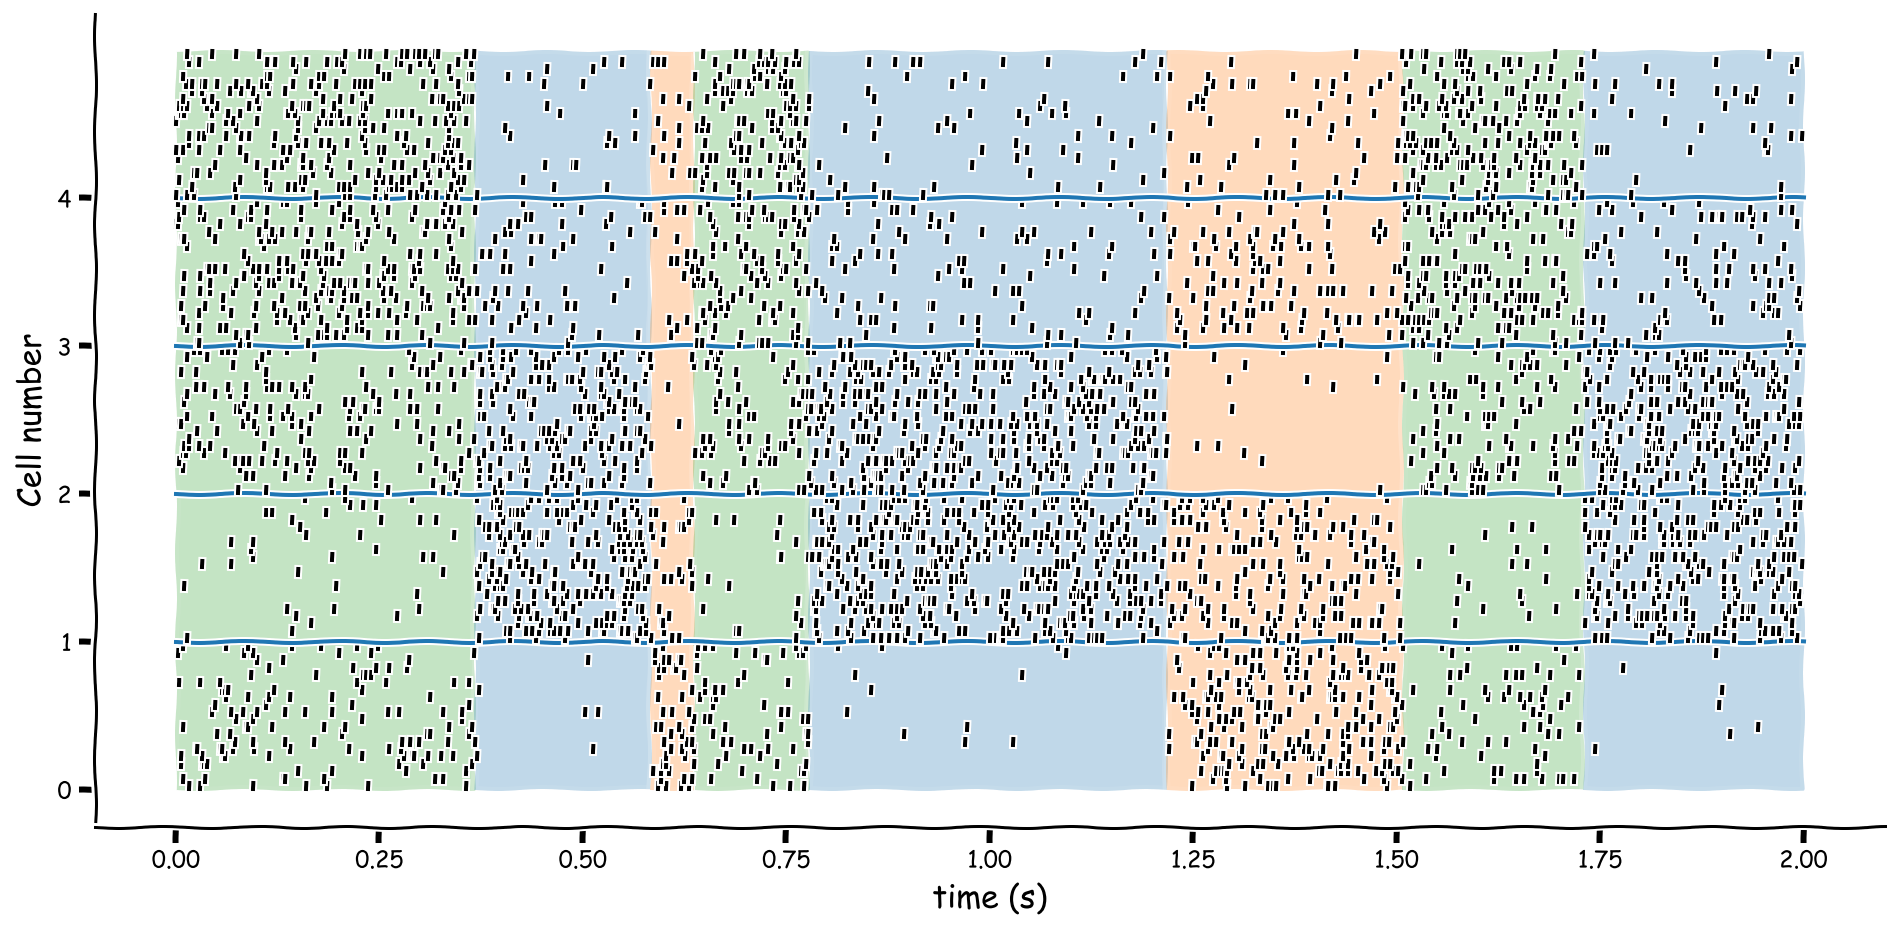

In [ ]:
np.random.seed(101)
# sample n_frozen_trials state sequences
Xf = np.zeros(T, dtype=int)
Xf[0] = (psi.cumsum() > np.random.rand()).argmax()
for t in range(1, T):
    Xf[t] = (A[Xf[t - 1],:].cumsum() > np.random.rand()).argmax()

# switch to one-hot encoding of the state
Xf = np.eye(K, dtype=int)[Xf]  # (T,K)

# get the Y values
Rates = np.squeeze(L @ Xf[..., None]) * dt  # (T,C)

Rates = np.tile(Rates, [n_frozen_trials, 1, 1]) # (n_trials, T, C)
Yf = stats.poisson(Rates).rvs()

with plt.xkcd():
  plot_spike_train(Xf, Yf, dt)

#### Generate data for EM learning

The previous dataset is generated with the same state sequence for visualization. Now let's generate `n_trials` trials of observations, each one with its own randomly generated sequence

In [ ]:
np.random.seed(101)
# sample n_trials state sequences
X = np.zeros((n_trials, T), dtype=int)
X[:, 0] = (psi_true.cumsum(0)[:, None] > np.random.rand(n_trials)).argmax(0)
for t in range(1, T):
  X[:, t] = (A_true[X[:, t - 1], :].T.cumsum(0) > np.random.rand(n_trials)).argmax(0)

# switch to one-hot encoding of the state
one_hot = np.eye(K)[np.array(X).reshape(-1)]
X = one_hot.reshape(list(X.shape) + [K])

# get the Y values
Y = stats.poisson(np.squeeze(L_true @ X[..., None]) * dt).rvs()  # (n_trials, T, C)
print("Y has shape: (n_trial={},T={},C={})".format(*Y.shape))

Y has shape: (n_trial=300,T=1000,C=5)


# ADVICE FROM NMA  
We, the organizers, know that the next section is much longer and more challenging than most other tutorial content. **We do not expect you to finish it—or even start it—right now**. In fact, we strongly suggest saving your time and energy for the Kalman Filtering introduced in Tutorial 3, because it will play an important role in tomorrow's material too. Since Kalman filters also use the E-M algorithm, learning about them first may provide you with useful intuitions about this material. 

That said, the EM algorithm can be a very useful and powerful optimization tool. Since it is typically taught in the context of Hidden Markov Models, we have included it here for your reference. 

To reiterate, the remainder of this notebook is *completely* and *absolutely* optional. It is not essential to understand the rest of the NMA content. By this point in Tutorial 2, we believe that you will have seen enough about HMMs to know when/if they might be relevant for your own research. When that day comes, or you are just feeling curious, this material will be here waiting! 

---

## **Optional** Section: EM algorithm for HMM

Video available at https://youtu.be/umU4wUWlKvg


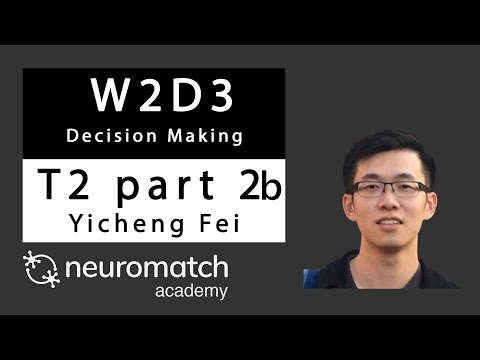

In [ ]:
#@title Video 6: EM Tutorial
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="umU4wUWlKvg", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Finding the optimal values of parameters that maximizes the data likelihood is practically infeasible since we need to integrating out all latent variables $x_{1:T}$. The time needed is exponential to $T$. Thus as an alternative approach, we use the Expectation-Maximization algorithm, which iteratively performing a E-step followed by a M-step and is guaranteed to not decrease(usually increase) the data likelihood after each EM cycle.


In this section we will briefly review the EM algorithm  for HMM and list

* Recursive equations for forward and backward probabilities $a_i(t)$ and $b_i(t)$
* Expressions for singleton and pairwise marginal distributions after seeing data: $\gamma_{i}(t):=p_{\theta}\left(x_{t}=i | Y_{1: T}\right)$ and $\xi_{i j}(t) = p_{\theta}(x_t=i,x_{t+1}=j|Y_{1:T})$
* Closed-form solutions for updated values of $A,\psi,\lambda$ which increases data likelihood


---
#### E-step: Forward-backward algorithm 
In the forward pass, we calculate the **forward probabilities**, or the joint probability of $x_t$ and current and past data $Y_{1:t}$: $a_i(t):=p(x_t=i,Y_{1:t})$ recursively by

$$a_i(t) = p_(y_t|x_i=t)\sum_j A_{ji} a_j(t-1)$$

In contrast to the intro, now $A_{ji}$ means **the transition probability from state $j$ to state $i$.**

The backward pass calculate the **backward probabilities** $b_i(t):=p_{\theta}(Y_{t+1:T}|x_t=i)$, which is the likelihood of observing all future data points given current state $x_t$. The recursion of $b_i(t)$ is given by 

$$ b_i(t) = \sum_j p_{\theta}(y_{t+1}|x_{t+1}=j)b_j(t+1)A_{ij} $$

Combining all past and future information, the **singleton and pairwise marginal distributions** are given by 

$$ \gamma_{i}(t):=p_{\theta}\left(x_{t}=i | Y_{1: T}\right)=\frac{a_{i}(t) b_{i}(t)}{p_{\theta}\left(Y_{1: T}\right)} $$ 

$$  \xi_{i j}(t) = p_{\theta}(x_t=i,x_{t+1}=j|Y_{1:T}) =\frac{b_{j}(t+1)p_{\theta}\left(y_{t+1} | x_{t+1}=j\right) A_{i j} a_{i}(t)}{p_{\theta}\left(Y_{1: T}\right)} $$

where $p_{\theta}(Y_{1:T})=\sum_i a_i(T)$.

---
#### M-step

The M-step for HMM has a closed-form solution. First the new transition matrix is given by 
$$ 
 A_{ij} =\frac{\sum_{t=1}^{T-1} \xi_{i j}(t)}{\sum_{t=1}^{T-1} \gamma_{i}(t)}
$$

which is the expected empirical transition probabilities. 
New initial probabilities and parameters of the emission models are also given by their empirical values given single and pairwise marginal distributions:

$$ \psi_i = \frac{1}{N}\sum_{trials}\gamma_i(1) $$ 

$$ \lambda_{i}^{c}=\frac{\sum_{t} \gamma_{i}(t) y_{t}^{c}}{\sum_{t} \gamma_{i}(t) d t}$$

---


### E-step: forward and backward algorithm

**(Optional)**

In this section you will read through the code for the forward-backward algorithm and understand how to implement the computation efficiently in `numpy` by calculating the recursion for all trials at once.

---

Let's re-write the forward and backward recursions in a more compact form:

$$ a_i^t = \sum_j A_{ji}o_j^t a_j^{t-1}  $$


$$b^t_i = \sum_j A_{ij} o_j^{t+1}b_j^{t+1} $$ where $o_j^{t}=p(y_{t}|x_{t}=j)$.


Let's take the backward recursion for example. In practice we will handle all trials together since they are independent of each other. After adding a trial index $l$ to the recursion equations, the backward recursion becomes:

$$b^t_{li} = \sum_j A_{ij} o_{lj}^{t+1}b_{lj}^{t+1} $$ 

What we have in hand are:
* `A`: matrix of size `(K,K)`
* `o^{t+1}`: array of size `(N,K)` is the log data likelihood for all trials at a given time
* `b^{t+1}`: array of size `(N,K)` is the backward probability for all trials at a given time

where `N` stands for the number of trials.

The index size and meaning doesn't match for these three arrays: the index is $i$ for $A$ in the first dimension and is $l$ for $o$ and $b$, so we can't just multiply them together. However, we can do this by viewing vectors $o^{t+1}_{l\cdot}$ and $b^{t+1}_{l\cdot}$ as a matrix with 1 row and re-write the backward equation as:

$$b^t_{li} = \sum_j A_{ij} o_{l1j}^{t+1}b_{l1j}^{t+1} $$

Now we can just multiply these three arrays element-wise and sum over the last dimension.

In `numpy`, we can achieve this by indexing the array with `None` at the location we want to insert a dimension. Take `b` with size `(N,T,K)` for example,`b[:,t,:]` will have shape `(N,K)`, `b[:,t,None,:]` will have shape `(N,1,K)` and `b[:,t,:,None]` will have shape `(N,K,1)`.

So the backward recursion computation can be implemented as 

```python
b[:,t,:] = (A * o[:,t+1,None,:] * b[:,t+1,None,:]).sum(-1)
```

---

In addition to the trick introduced above, in this exercise we will work in the **log scale** for numerical stability.


**Suggestions** 

1. Take a look at the code for the forward recursion and backward recursion.

    




In [ ]:
def e_step(Y, psi, A, L, dt):
  """Calculate the E-step for the HMM spiking model.

  Args:
    Y (numpy 3d array): tensor of recordings, has shape (n_trials, T, C)
    psi (numpy vector): initial probabilities for each state
    A (numpy matrix):   transition matrix, A[i,j] represents the prob to
                        switch from i to j. Has shape (K,K)
    L (numpy matrix):   Poisson rate parameter for different cells.
                        Has shape (C,K)
    dt (float):         Bin length

  Returns:
    ll (float):             data log likelihood
    gamma (numpy 3d array): singleton marginal distribution.
                            Has shape (n_trials, T, K)
    xi (numpy 4d array):    pairwise marginal distribution for adjacent
                            nodes . Has shape (n_trials, T-1, K, K)
  """
  n_trials = Y.shape[0]
  T = Y.shape[1]
  K = psi.size
  log_a = np.zeros((n_trials, T, K))
  log_b = np.zeros((n_trials, T, K))

  log_A = np.log(A)
  log_obs = stats.poisson(L * dt).logpmf(Y[..., None]).sum(-2)  # n_trials, T, K

  # forward pass
  log_a[:, 0] = log_obs[:, 0] + np.log(psi)
  for t in range(1, T):
    tmp = log_A + log_a[:, t - 1, : ,None]  # (n_trials, K,K)
    maxtmp = tmp.max(-2)  # (n_trials,K)
    log_a[:, t] = (log_obs[:, t] + maxtmp +
                    np.log(np.exp(tmp - maxtmp[:, None]).sum(-2)))

  # backward pass
  for t in range(T - 2, -1, -1):
    tmp = log_A + log_b[:, t + 1, None] + log_obs[:, t + 1, None]
    maxtmp = tmp.max(-1)
    log_b[:, t] = maxtmp + np.log(np.exp(tmp - maxtmp[..., None]).sum(-1))

  # data log likelihood 
  maxtmp = log_a[:, -1].max(-1)
  ll = np.log(np.exp(log_a[:, -1] - maxtmp[:, None]).sum(-1)) + maxtmp
  
  # singleton and pairwise marginal distributions 
  gamma = np.exp(log_a + log_b - ll[:, None, None])
  xi = np.exp(log_a[:, :-1, :, None] + (log_obs + log_b)[:, 1:, None] +
              log_A - ll[:, None, None, None])

  return ll.mean() / T / dt, gamma, xi

Video available at https://youtu.be/H4GGTg_9BaE


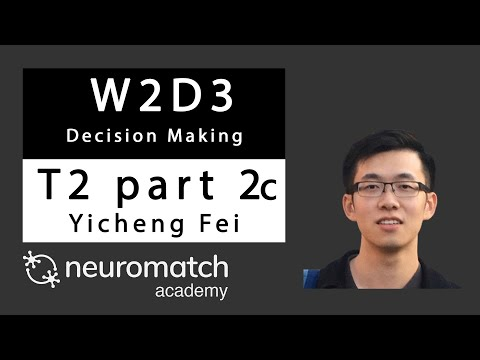

In [ ]:
#@title EXERCISE 7: Implement the M-step Video
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="H4GGTg_9BaE", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---

### EXERCISE 5: Implement the M-step

In this exercise you will complete the M-step for this HMM using closed form solutions mentioned before.

**Suggestions**

1. Calculate new initial probabilities as empirical counts of singleton marginals

$$ \psi_i = \frac{1}{N}\sum_{trials}\gamma_i(1) $$

2. Remember the extra trial dimension and average over all trials


**For reference:**

New transition matrix is calculated as empirical counts of transition events from marginals

$$ A_{ij} =\frac{\sum_{t=1}^{T-1} \xi_{i j}(t)}{\sum_{t=1}^{T-1} \gamma_{i}(t)}$$ 


New spiking rates for each cell and each state are given by

$$  \lambda_{i}^{c}=\frac{\sum_{t} \gamma_{i}(t) y_{t}^{c}}{\sum_{t} \gamma_{i}(t) d t} $$


In [ ]:
def m_step(gamma, xi, dt):
  """Calculate the M-step updates for the HMM spiking model.

  Args:
    gamma ():       Number of epochs of EM to run
    xi (numpy 3d array): Tensor of recordings, has shape (n_trials, T, C)
    dt (float):         Duration of a time bin

  Returns:
    psi_new (numpy vector): Updated initial probabilities for each state
    A_new (numpy matrix):   Updated transition matrix, A[i,j] represents the
                            prob. to switch from j to i. Has shape (K,K)
    L_new (numpy matrix):   Updated Poisson rate parameter for different
                            cells. Has shape (C,K)
  """
  raise NotImplementedError("`m_step` need to be implemented")
  ############################################################################
  # Insert your code here to:
  #    Calculate the new prior probabilities in each state at time 0
  #    Hint: Take the first time step and average over all trials
  ###########################################################################
  psi_new = ...
  # Make sure the probabilities are normalized
  psi_new /= psi_new.sum()

  # Calculate new transition matrix
  A_new = xi.sum(axis=(0, 1)) / gamma[:, :-1].sum(axis=(0, 1))[:, np.newaxis]
  # Calculate new firing rates
  L_new = (np.swapaxes(Y, -1, -2) @ gamma).sum(axis=0) / gamma.sum(axis=(0, 1)) / dt
  return psi_new, A_new, L_new

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D3_DecisionMaking/solutions/W2D3_Tutorial2_Solution_29c675cb.py)



Video available at https://youtu.be/6UTsXxE3hG0


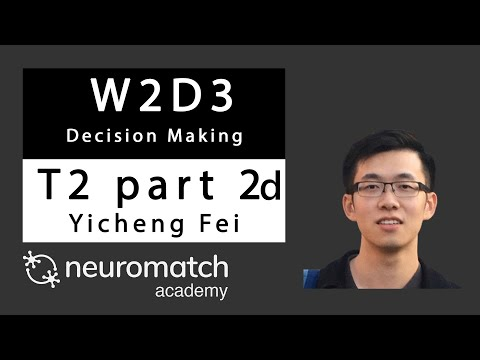

In [ ]:
#@title Video 8: Running and plotting EM
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="6UTsXxE3hG0", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---

### Run EM

####Initialization for parameters


In [ ]:
np.random.seed(101)
# number of EM steps
epochs = 9
print_every = 1

# initial state distribution
psi = np.arange(1, K + 1)
psi = psi / psi.sum()

# off-diagonal transition rates sampled uniformly
A = np.ones((K, K)) * max_transition_rate * dt / 2
A = (1 - np.eye(K)) * A
A = A + np.diag(1 - A.sum(1))

# firing rates sampled uniformly
L = np.random.rand(C, K) * max_firing_rate

In [ ]:
# LL for true vs. initial parameters
print(f'LL for true 𝜃:    {e_step(Y, psi_true, A_true, L_true, dt)[0]}')
print(f'LL for initial 𝜃: {e_step(Y, psi, A, L, dt)[0]}\n')

# Run EM
save_vals, lls, psi, A, L = run_em(epochs, Y, psi, A, L, dt)

LL for true 𝜃:    -455.8684143040628


LL for initial 𝜃: -481.5065734432824



epoch:   0, ll = -481.5065734432824


epoch:   1, ll = -461.8610532934206


epoch:   2, ll = -456.5662172692457


epoch:   3, ll = -455.9130201971624


epoch:   4, ll = -455.8576708791359


epoch:   5, ll = -455.8475179733172


epoch:   6, ll = -455.8443865680103


epoch:   7, ll = -455.8431170392863


epoch:   8, ll = -455.8425100302352


epoch:   9, ll = -455.8421872772487


In [ ]:
# EM doesn't guarantee the order of learnt latent states are the same as that of true model
# so we need to sort learnt parameters

# Compare all true and estimated latents across cells
cost_mat = np.sum((L_true[..., np.newaxis] - L[:, np.newaxis])**2, axis=0)
true_ind, est_ind = linear_sum_assignment(cost_mat)

psi = psi[est_ind]
A = A[est_ind]
A = A[:, est_ind]
L = L[:, est_ind]

---
## **Optional** Section: Plotting the training process and learnt model

### Plotting progress during EM!

Now you can

* Plot the likelihood during training
* Plot the M-step log likelihood versus expected complete log likelihood(ECLL) to get an intuition of how EM works and the convexity of ECLL
* Plot learnt parameters versus true parameters 

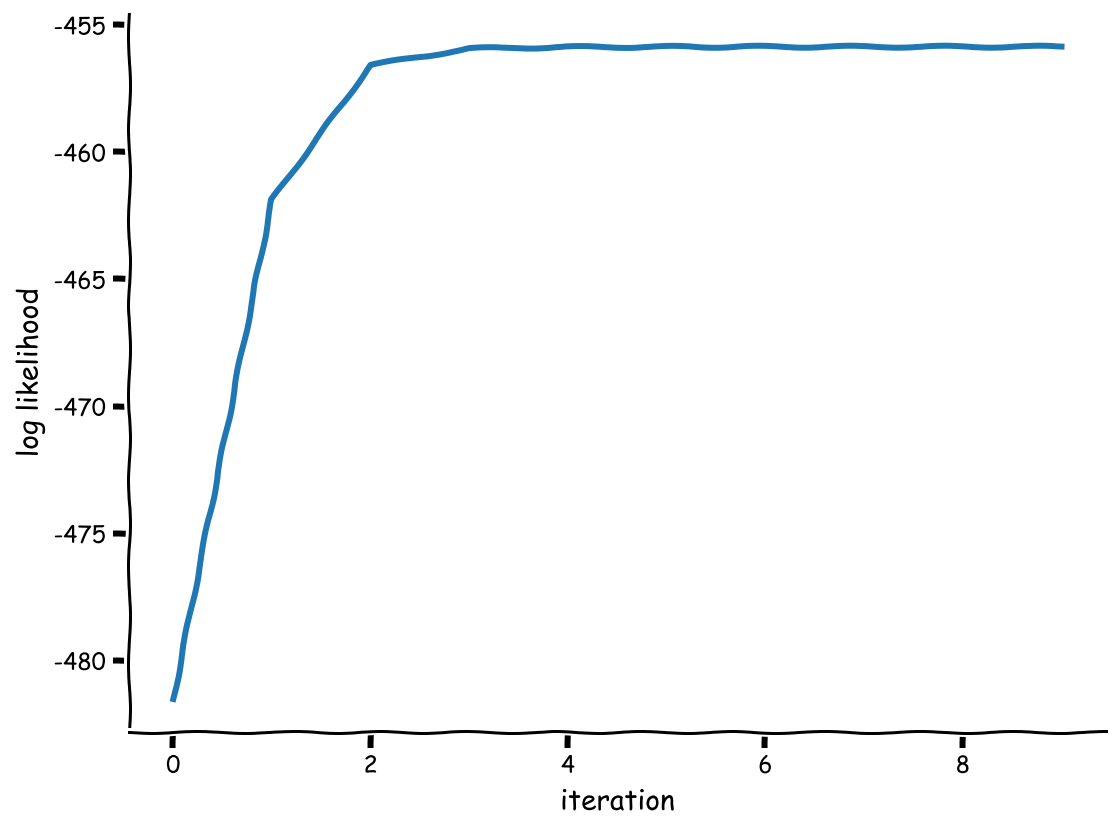

In [ ]:
# Plot the log likelihood after each epoch of EM
with plt.xkcd():
  plot_lls(lls)

/opt/hostedtoolcache/Python/3.7.8/x64/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/hostedtoolcache/Python/3.7.8/x64/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/hostedtoolcache/Python/3.7.8/x64/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged neste

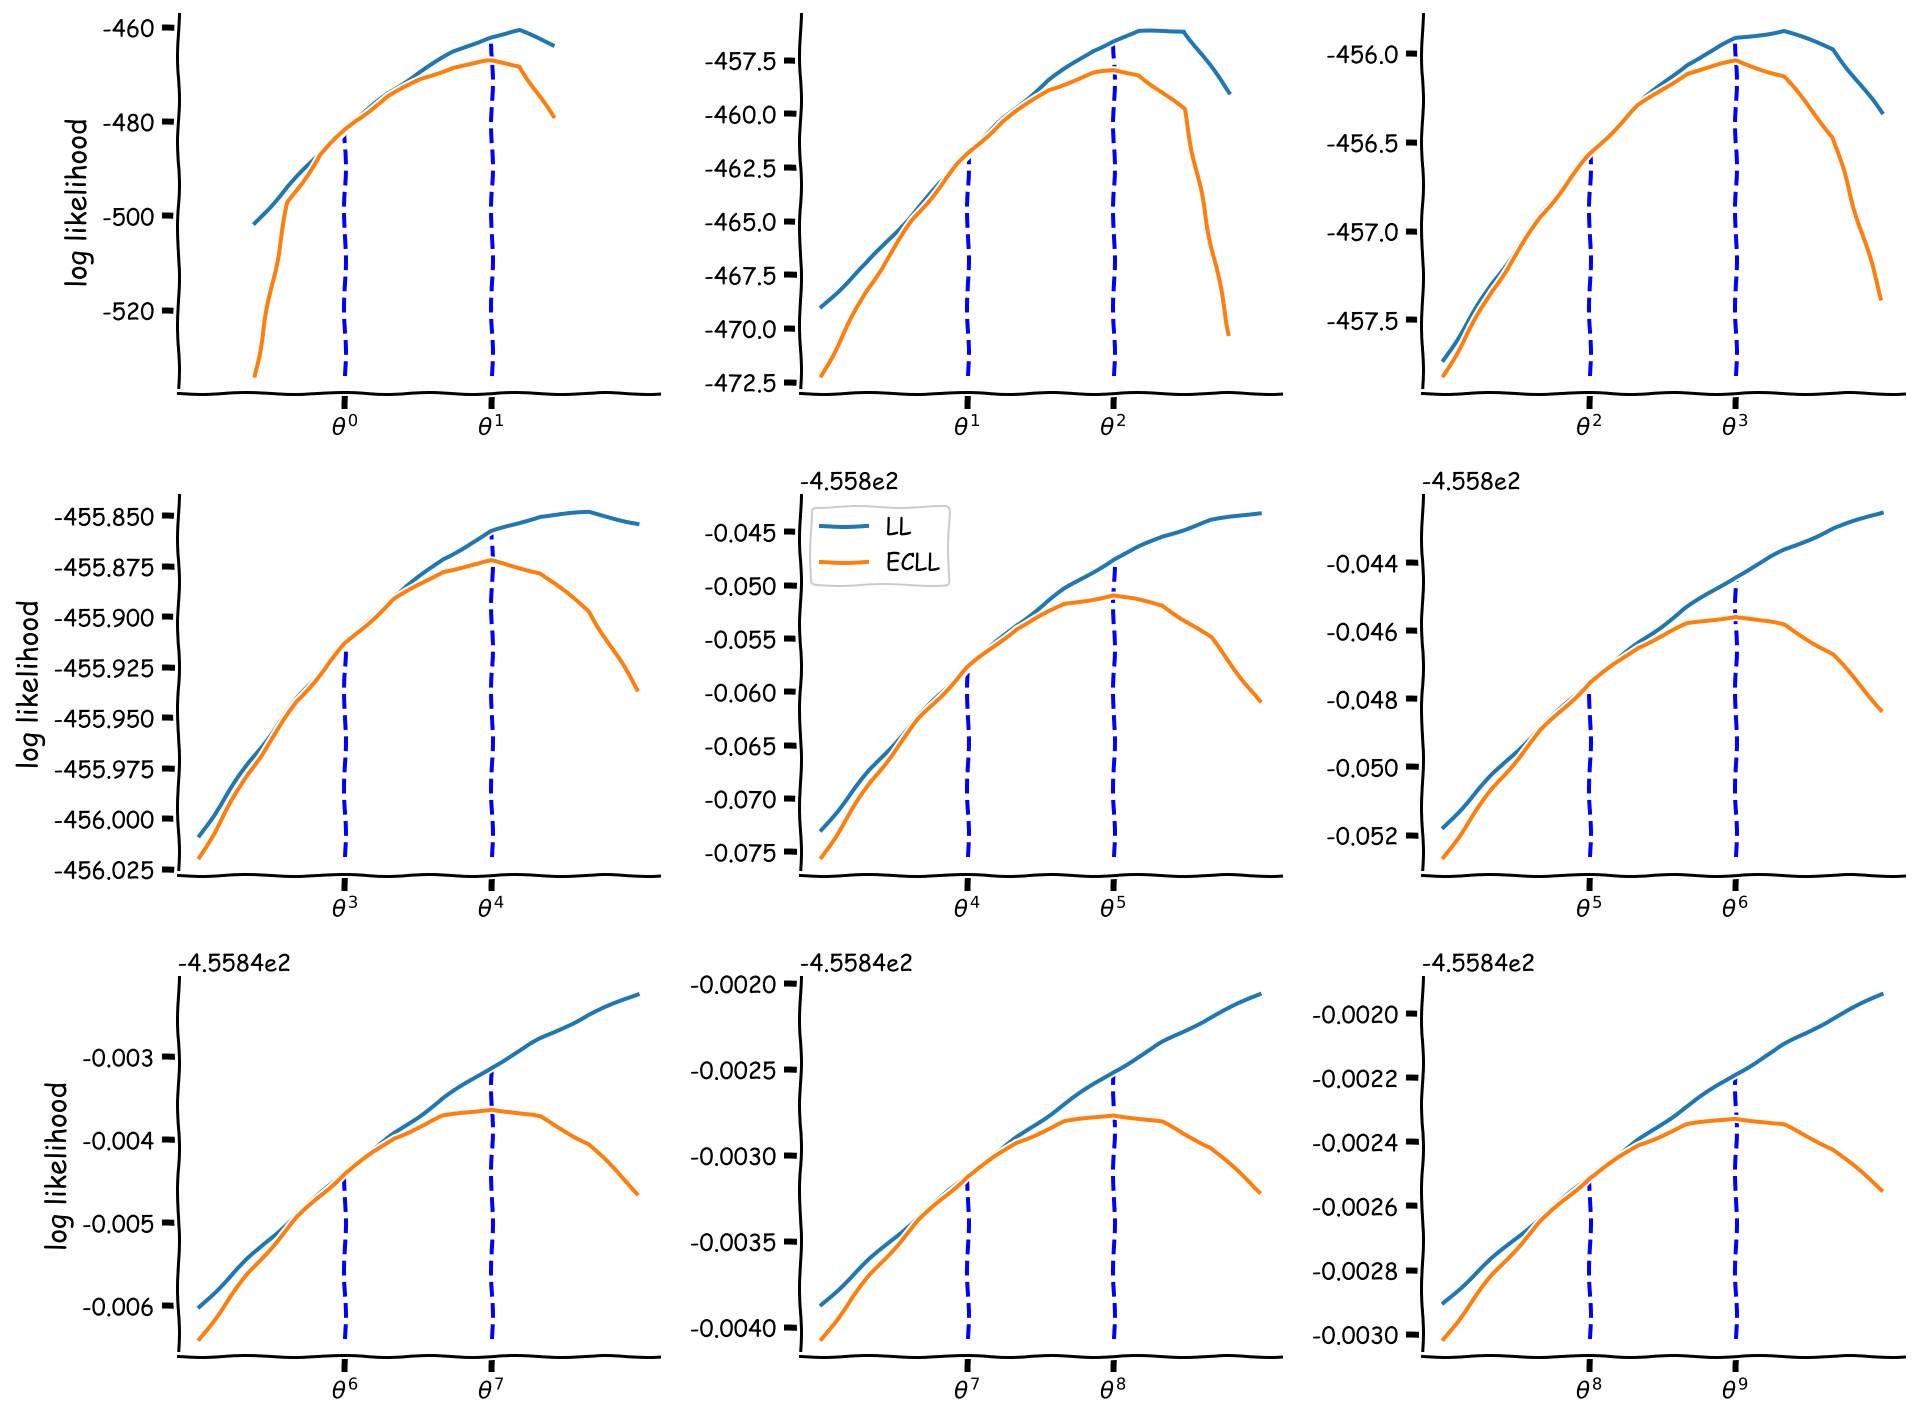

In [ ]:
# For each saved epoch, plot the log likelihood and expected complete log likelihood
# for the initial and final parameter values
with plt.xkcd():
  plot_lls_eclls(plot_epochs, save_vals)

### Plot learnt parameters vs. true parameters

Now we will plot the (sorted) learnt parameters with true parameters to see if we successfully recovered all the parameters


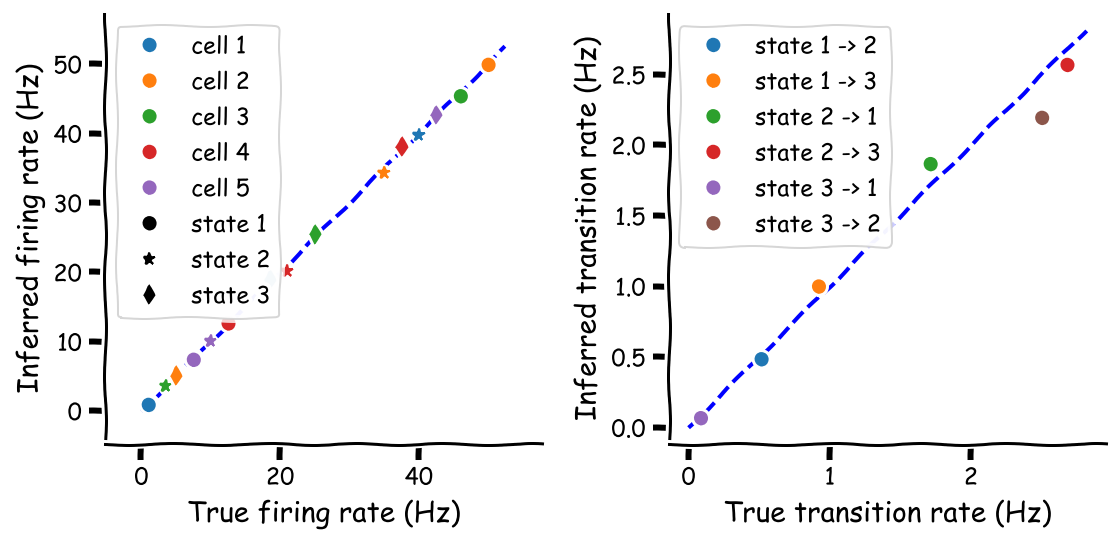

In [ ]:
# Compare true and learnt parameters
with plt.xkcd():
  plot_learnt_vs_true(L_true, L, A_true, A, dt)